# Variational AutoEncoder in a Nutshell

Variational Autoencoders (or VAEs) are generative, can be used to manipulate datasets by learning the distribution of this input data. But there’s a difference between theory and practice. While it’s always nice to understand neural networks in theory, it’s always even more fun to actually create them with a particular framework. It makes them really usable.

In this tutorial, we will be discussing how to train a variational autoencoder(VAE) with Keras(TensorFlow, Python) from scratch. We will be concluding our study with the demonstration of the generative capabilities of a simple VAE.
The rest of the content in this tutorial can be classified as the following-
0. Background: Variational AutoEncoders (VAEs)

1. Building VAE in Keras
2. Training VAE on the MNIST dataset
3. Results
4. Image Generation Capabilities
5. Summary
6. Further reading and resources

[OP](https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb), modified by Dr. Jie Tao.

## What are VAEs?

An autoencoder is basically a neural network that takes a high dimensional data point as input, converts it into a lower-dimensional feature vector(ie., latent vector), and later reconstructs the original input sample just utilizing the latent vector representation without losing valuable information. Any given autoencoder is consists of the following two parts-an Encoder and a Decoder. The Encoder part of the model takes an input data sample and compresses it into a latent vector. While the decoder part is responsible for recreating the original input sample from the learned(learned by the encoder during training) latent representation.

Contrary to a [normal autoencoder](https://www.machinecurve.com/index.php/2019/12/24/what-is-a-variational-autoencoder-vae/#about-normal-autoencoders), which learns to encode some input into a point in latent space, Variational Autoencoders (VAEs) learn to encode multivariate probability distributions into latent space, given their configuration usually Gaussian ones:

![VAE](https://www.machinecurve.com/wp-content/uploads/2019/12/vae-encoder-decoder.png)

Sampling from the distribution gives a point in latent space that, given the distribution, is oriented around some mean value $\mu$ and standard deviation $\sigma$, like the points in this two-dimensional distribution:

![latent distribution](https://www.machinecurve.com/wp-content/uploads/2019/12/MultivariateNormal.png)

Unlike normal autoencoders (where we use basic reconstruction loss as the loss function), we use the [Kullback-Leibler divergence segment](https://www.machinecurve.com/index.php/2019/12/21/how-to-use-kullback-leibler-divergence-kl-divergence-with-keras/) in the loss function leads to a latent space that is both continuous and complete: for every point sampled close to the distribution’s mean and standard deviation (which is in our case the standard normal distribution) the output should be both similar to samples around that sample and should make sense.

### Recap on Reconstruction Error

In the normal autoencoders, reconstruction error refers to the difference between the original data $x$ and the generated/reconstructed data $\bar{x}$.

What makes the KL-reconstruction error different is that instead of comparing if $x$ and $\bar{x}$ are similar, we are comparing the distributions of $x$ ($\phi(x)$) and ($\phi(\bar{x})$) is similar.

In other words, in normal autoencoder, we wish that the orginal data and the reconstructed data are of the same order, contain the same elements, etc.; whereas in VAE, we care more about the distributions, in particular mean values $\mu_{x}$ and $\mu_{\bar{x}}$, as well as standard deviations $\sigma_{x}$ and $\sigma_{\bar{x}}$, are similar. Since $x$ and $\bar{x}$ are of the same type of distribution, if $\mu$ and $\sigma$ are similar, the two distributions are similar.

## Kullback–Leibler (KL) divergence

In the last section, we were talking about enforcing a standard normal distribution on the latent features of the input dataset. This can be accomplished using KL-divergence statistics. KL-divergence is a statistical measure of the difference between two probabilistic distributions. Thus, we will utilize KL-divergence value as an objective function(along with the reconstruction loss) in order to ensure that the learned distribution is very similar to the true distribution, which we have already assumed to be a standard normal distribution.

In this case, the final objective can be written as-

```Objective = Reconstruction Loss + KL-Loss```

Here, the reconstruction loss term would encourage the model to learn the important latent features, needed to correctly reconstruct the original image (if not exactly the same, an image of the same class). While the KL-divergence-loss term would ensure that the learned distribution is similar to the true distribution(a standard normal distribution). This further means that the distribution is centered at zero and is well-spread in the space. We will prove this one also in the latter part of the tutorial.


## How do we use VAEs?

Since with the use of VAE, $x$ and $\bar{x}$ are not essentially the same but of the same/similar distribution (that's where the __variational__ part comes in), the use of VAE is somewhat different than regular AEs.

Besides the regular stuff one can do with an autoencoder (like denoising and dimensionality reduction), the principles of a VAE outlined above allow us to use variational autoencoders for generative purposes.

I would really recommend this blog “[What is a Variational Autoencoder (VAE)?](https://www.machinecurve.com/index.php/2019/12/24/what-is-a-variational-autoencoder-vae/)” if you are interested in understanding VAEs in more detail. However, based on the high-level recap above, I hope that you now both understand (1) how VAEs work at a high level and (2) what this allows you to do with them: using them for generative purposes.

## Creating a VAE with Keras

Today, we’ll use the [Keras](https://keras.io/) deep learning framework for creating a VAE. It consists of three individual parts: the encoder, the decoder and the VAE as a whole. We do so using the Keras Functional API, which allows us to combine layers very easily.

This section can be broken into the following parts for step-wise understanding and simplicity-
1. Data Preparation
2. Building Encoder
3. Latent Distribution and Sampling
4. Building Decoder
5. Building VAE
6. Tweak the Loss Function


The MNIST dataset will be used for training the autoencoder. This dataset contains thousands of `28 x 28` pixel images of handwritten digits, as we can see below. As such, our autoencoder will learn the distribution of handwritten digits across (two)dimensional latent space, which we can then use to manipulate samples into a format we like.

### Model imports
Let’s now declare everything that we will import:

- Keras, obviously.
- From Keras Layers, we’ll need __convolutional__  and __transposed convolutions__ layers, which we’ll use for the autoencoder. Given our usage of the Functional API, we also need __Input, Lambda__ and __Reshape__, as well as __Dense__ and __Flatten__.
  - __convolutional__ and __transposed convolutions__ layers are opposite of each other so if we use the former in the _encoder_ we can use the latter in _decoder_;
  - the reason we do not need __MaxPooling__ is that we do not try to classify the images;
- We’ll import __BatchNormalization__ as well to ensure that the mean and variance of our layer’s inputs remains close to `(0, 1)` during training. This benefits the training process.
- We’ll import the __Model__ container from `keras.models`. This allows us to instantiate the models eventually, and is used when the `sequential` API is used.
- The _MNIST_ dataset is the dataset we’ll be training our VAE on.
- With `binary_crossentropy`, we can compute reconstruction loss.
  - since we treat each pixel in the images as a categorical value, we will not use _RMSE_ or _MAE_ as the loss function.
- Our backend (`K`) contains calls for tensor manipulations, which we’ll use `tensorflow` for.
- __Numpy__ is used for number processing and Matplotlib for plotting the visualizations on screen.

In [ ]:
# from tensorflow import keras
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
# import numpy as np
# import matplotlib.pyplot as plt
%tensorflow_version 1.x
#### basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

#### for loading the data
from tensorflow.keras.datasets import mnist


#### for defining the encoder/decoder model
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense, Lambda
from tensorflow.keras.layers import MaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

TensorFlow 1.x selected.


## Data Preparation
In this section, we are going to download and load the MNIST handwritten digits dataset into our Python notebook to get started with the data preparation.
Here are the dependencies, loaded in advance-


11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


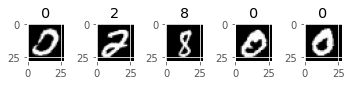

In [ ]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()
print('Training data shapes: X=%s, y=%s' % (input_train.shape, target_train.shape))
print('Testing data shapes: X=%s, y=%s' % (input_test.shape, target_test.shape))
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(input_train[i], cmap='gray')
    plt.title(target_train[i])
plt.show()

Dataset is already divided into the **training** and **test** set. The training dataset has `60K` handwritten digit images with a resolution of `28*28`. While the Test dataset consists of `10K` handwritten digit images with similar dimensions.

### Model configuration
Importing the data is followed by setting config parameters for data and model.

In [ ]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_test.shape[2] # 28, 28
batch_size = 128
no_epochs = 100
validation_split = 0.2 # 20% for validation
verbosity = 1
latent_dim = 2 # we set the latent dimension to be 2 so that we can easily visualize them without PCA or T-SNE
num_channels = 1 # since the MNIST dataset is grayscale, we set this to 1, if it's RGB then it should be 3

### Data preprocessing
The next thing is data preprocessing:

- First, we reshape the data so that it takes the shape `(X, 28, 28, 1)`, where `X` is the number of samples in either the training or testing dataset. We also set `(28, 28, 1)` as `input_shape` - which we will use in the `Input` layer of the VAE.

- Next, we parse the numbers as floats, which presumably __speeds up the training process__, and normalize it, which the neural network appreciates. And that’s it already for data preprocessing

In [ ]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

### Creating the encoder

In this section, we will define the encoder part of our VAE model. The encoder part of the autoencoder usually consists of multiple repeating convolutional layers followed by pooling layers when the input data type is images. The encoder part of a variational autoencoder is also quite similar, it’s just the bottleneck part that is slightly different as discussed above.
Here is the python implementation of the encoder part with Keras-


#### Encoder definition
The first step in the three-step process is the definition of our encoder. Following the connection process of the Keras Functional API, we link the layers together:

- The first layer is the Input layer. It accepts data with input_shape = `(28, 28, 1)` and is named encoder_input.
- Next up is a two-dimensional convolutional layer, or `Conv2D` in Keras terms. It learns `8` filters by deploying a $3 \times 3$ kernel which it convolves over the input. It has a stride of `2` which means that it skips over the input during the convolution as well, speeding up the learning process. It employs `same` padding and `ReLU` activation. Do note that officially, it’s best to use [He init](https://www.machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely/) with [ReLU](https://www.machinecurve.com/index.php/2019/09/04/relu-sigmoid-and-tanh-todays-most-used-activation-functions/) activating layers. However, since the dataset is relatively small, it shouldn’t be too much of a problem if you don’t.
- Subsequently, we use Batch Normalization. This layer ensures that the outputs of the Conv2D layer that are input to the next Conv2D layer have a steady mean and variance, likely $\mu=0.0,\sigma=1.0$ (plus some $\epsilon$, an error term to ensure numerical stability). This benefits the learning process.
- Once again, a Conv2D layer. It learns `16` filters and for the rest is the same as the first Conv2D layer.
- BatchNormalization once more.
- Next up, a Flatten layer. It’s a relatively dumb layer too, and only serves to flatten the multidimensional data from the convolutional layers into one-dimensional shape. This has to be done because the densely-connected layers that we use next require data to have this shape.
- The next layer is a Dense layer with 20 output neurons. It’s the autoencoder bottleneck we’ve been talking about.
- BatchNormalization once more.
- The next two layers, `mu` and `sigma`, are actually not separate from each other – look at the previous layer they are linked to (both `x`, i.e. the `Dense(20)` layer). The first outputs the mean values $\mu$ of the encoded input and the second one outputs the stddevs $\sigma$. With these, we can sample the random variables that constitute the point in latent space onto which some input is mapped.

In [ ]:
input_data = Input(shape=(28, 28, 1))
#### have 64 5 by 5 windows
encoder = Conv2D(64, (5,5), activation='relu')(input_data)
#### pair with maxpooling for convolution
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(64, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Conv2D(32, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
#### flatten to be a 1D vector
encoder = Flatten()(encoder)
encoder = Dense(16)(encoder)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


The above snippet compresses the image input and brings down it to a `16` valued (`4*4`) feature vector, but these are not the final latent features. The next section will complete the encoder part by adding the latent features computational logic into it.

### Latent Distribution and Sampling
This section is responsible for taking the convoluted features (e.g., the `4*4` vectors) from the last section and calculating the **mean** and **log-variance** of the latent features (As we have assumed that the latent features follow a **standard normal distribution**, and the distribution can be represented with mean and variance statistical values). Two separate fully connected (_FC layers_) layers are used for calculating the **mean** and **log-variance** for the input samples of a given dataset.

These attributes(mean and log-variance) of the standard normal distribution(SND) are then used to estimate the **latent encodings** (which are used to reconstruct the corresponding input images) for the corresponding input data points. The function `sample_latent_features` defined below takes these two statistical values and returns back a latent encoding vector. This latent encoding is passed to the decoder as input for the image reconstruction purpose.

In [ ]:
# Define calculating the latent features
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = K.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random #### Calculating the KL Divergence

We then use this with a `Lambda` to ensure that correct gradients are computed during the backwards pass based on our values for `mu` (mean) and `sigma` (variance), as well as the latent features:

In [ ]:
# Use reparameterization trick to ensure correct gradient
distribution_mean = Dense(2, name='mean')(encoder)
distribution_variance = Dense(2, name='log_variance')(encoder)
latent_encoding = Lambda(sample_latent_features)([distribution_mean, distribution_variance])

### Encoder instantiation
These latent features(calculated from the learned distribution) actually complete the Encoder part of the model. Now the Encoder model can be defined as follow:

In [ ]:
# Instantiate encoder
encoder_model = Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

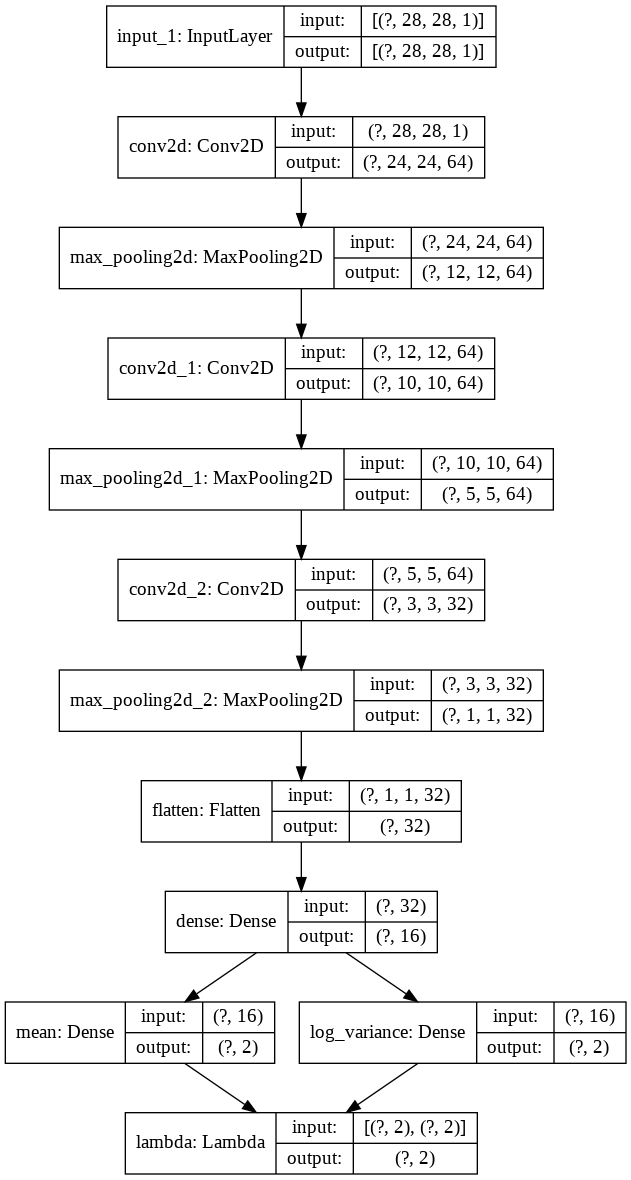

In [ ]:
plot_model(encoder_model, show_shapes=True)

The encoder is quite simple with just around `57K` trainable parameters.

Building Decoder
The Encoder part of the model takes an image as input and gives the latent encoding vector for it as output which is sampled from the learned distribution of the input dataset. The job of the decoder is to take this embedding vector as input and recreate the original image(or an image belonging to a similar class as the original image). As the latent vector is a quite compressed representation of the features, the decoder part is made up of multiple pairs of the Deconvolutional layers and upsampling layers. A deconvolutional layer basically reverses what a convolutional layer does. The upsampling layers are used to bring the original resolution of the image back. In this way, it reconstructs the image with original dimensions.
Here is the python implementation of the decoder part with Keras API from TensorFlow-

In [ ]:
# Definition - reverse the process of the encoder
decoder_input = Input(shape=(2))
decoder = Dense(64)(decoder_input)
decoder = Reshape((1, 1, 64))(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder_output = Conv2DTranspose(1, (5,5), activation='relu')(decoder)

### Decoder instantiation
The decoder model object can be defined as below-

In [ ]:
# Instantiate decoder
decoder_model = Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)        3692

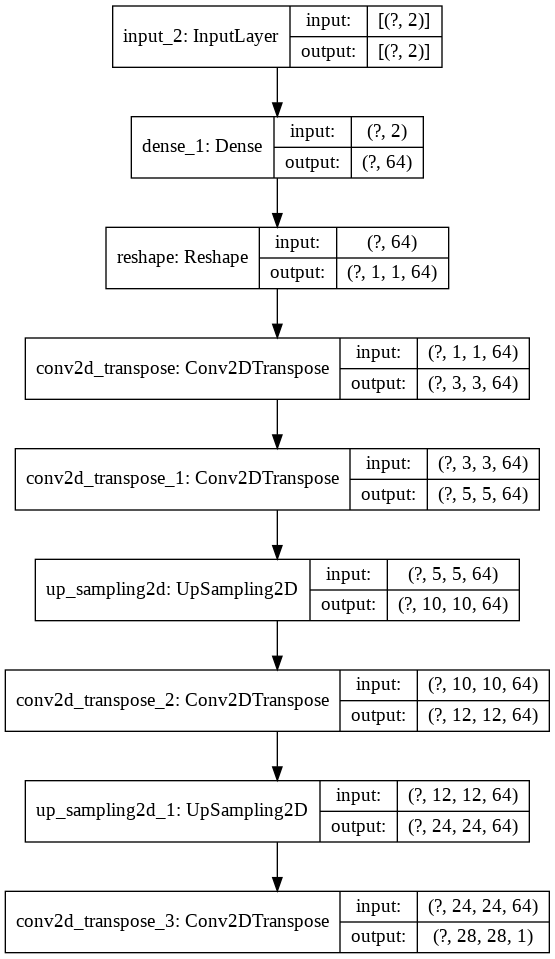

In [ ]:
plot_model(decoder_model, show_shapes=True)

## YOUR TURN HERE

Can you compare the structure of the `encoder` and `decoder` to see if they are symmetric?

DOUBLE CLICK HERE TO INUT YOUR ANSWER

## Assemble the VAE

Finally, the Variational Autoencoder(VAE) can be defined by combining the encoder and the decoder parts. Here is how you can create the VAE model object by sticking decoder after the encoder.


In [ ]:
# Instantiate VAE
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
vae = Model(input_data, decoded)
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 2)                 57652     
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


## Defining custom loss function

As discussed above, we need to define the KL divergence loss for the VAE, which is different from the normal AE.

Now that we have defined our model, we can proceed with model configuration. Usually, with neural networks, this is done with `model.compile`, where a loss function is specified such as __binary crossentropy__. However, when we look at how VAEs are optimized, we see that it’s not a simple loss function that is used: we use reconstruction loss (in our case, __binary crossentropy__ loss) together with __KL divergence__ loss to ensure that our latent space is both continuous and complete.

We define it as follows:

- Our `reconstruction_loss` is the binary crossentropy value computed for the flattened _true_ values (representing our targets, i.e. our ground truth) and the `pred` as the prediction values generated by our VAE. It’s multiplied with `img_width` and `img_height` to reduce the impact of flattening.
- Our KL divergence loss can be rewritten in the formula defined above (Wiseodd, 2016).
- We use `50%` reconstruction loss and `50%` KL divergence loss, and do so by returning the __sum__ between the two.

In [ ]:

def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

## Compilation & training

We can compile the model to make it ready for the training, and then just train it.

Just like the ordinary autoencoders, we will train it by giving exactly the same images for input as well as the output. The model is trained for `100` epochs with a batch size of `128`.

Here is the training summary-

In [ ]:
type(input_data)

tensorflow.python.framework.ops.Tensor

In [ ]:
# Compile VAE
vae.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')

# simple early stopping
# and save the best model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split, callbacks=[es, mc])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 144s 3ms/sample - loss: 47.5283 - val_loss: 40.4688
Epoch 2/100
48000/48000 [==============================] - 144s 3ms/sample - loss: 39.5424 - val_loss: 38.1677
Epoch 3/100
48000/48000 [==============================] - 144s 3ms/sample - loss: 38.0446 - val_loss: 37.0023
Epoch 4/100
48000/48000 [==============================] - 144s 3ms/sample - loss: 37.1126 - val_loss: 36.7534
Epoch 5/100
48000/48000 [==============================] - 143s 3ms/sample - loss: 36.4846 - val_loss: 36.3770
Epoch 6/100
48000/48000 [==============================] - 144s 3ms/sample - loss: 36.0277 - val_loss: 35.7933
Epoch 7/100
48000/48000 [==============================] - 143s 3ms/sample - loss: 35.6900 - val_loss: 35.0994
Epoch 8/100
48000/48000 [==============================] - 143s 3ms/sample - loss: 35.3930 - val_loss: 35.0996
Epoch 9/100
48000/48000 [==============================] - 143

I hope it can be trained a little more, but this is where the validation loss was not changing much and I went ahead with it.

## Results

In this section, we will see the reconstruction capabilities of our model on the test images. The following python script will pick 9 images from the test dataset and we will be plotting the corresponding reconstructed images for them.


Real Test Images


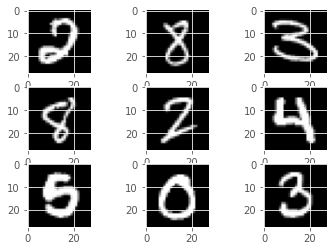

Reconstructed Images with Variational Autoencoder


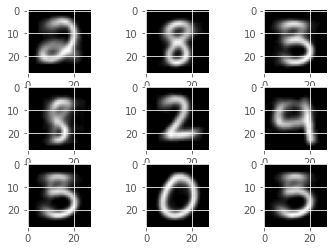

In [ ]:
offset=400

print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(input_test[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = vae.predict(np.array([input_test[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

The above results confirm that the model is able to reconstruct the digit images with decent efficiency. However, one important thing to notice here is that some of the reconstructed images are very different in appearance from the original images while the class(or digit) is always the same. This happens because, the reconstruction is not just dependent upon the input image, it is the distribution that has been learned. And this learned distribution is the reason for the introduced variations in the model output. This is interesting, isn’t it!

The second thing to notice here is that the output images are a little blurry. This is a common case with variational autoencoders, they often produce noisy(or poor quality) outputs as the latent vectors(bottleneck) is very small and there is a separate process of learning the latent features as discussed before. Variational Autoencoders(VAEs) are not actually designed to reconstruct the images, the real purpose is learning the distribution - and use it to better understand the data, or help with the classification.

### Latent Feature Clusters
As we have quoted earlier, the variational autoencoders(VAEs) learn the underlying distribution of the latent features, it basically means that the latent encodings of the samples belonging to the same class should not be very far from each other in the latent space. Secondly, the overall distribution should be standard normal, which is supposed to be centered at zero.

Let’s generate the latent embeddings for all of our test images and plot them(the same color represents the digits belonging to the same class, taken from the **ground truth** labels, `target_test`). Here is the python code-

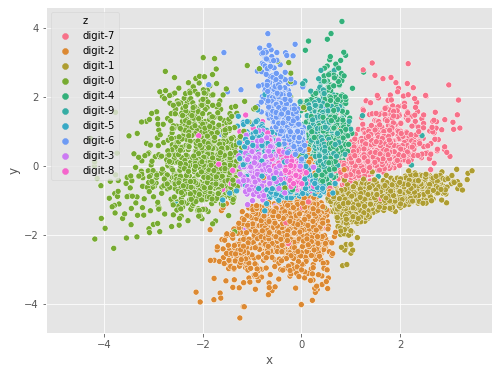

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(target_test[i])
    op = encoder_model.predict(np.array([input_test[i]]))
    x.append(op[0][0])
    y.append(op[0][1])
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

The above plot shows that the distribution is centered at zero. Embeddings of the same class digits are closer in the latent space. Digit separation boundaries can also be drawn easily. This is pretty much we wanted to achieve from the variational autoencoder.


### YOUR TURN HERE

Observe the image above, and explain why certain digits are closer/further from each other.

## Fake Image Generation

Although not very popular, VAEs can be used as generative models. The previous section shows that latent encodings of the input data are following a standard normal distribution and there are clear boundaries visible for different classes of the digits.

If we already know, which part of the space is dedicated to what class, we don’t even need input images to reconstruct the image. This means that we can actually generate digit images having similar characteristics as the training dataset by just passing the random points from the space (latent distribution space). In this fashion, VAEs can be used as generative models in order to generate fake data.

As we can see, the spread of latent encodings is in between `[-3, 3]` on the x-axis, and also `[-3, 3]` on the y-axis. Let’s generate a bunch of digits with random latent encodings belonging to this range only.

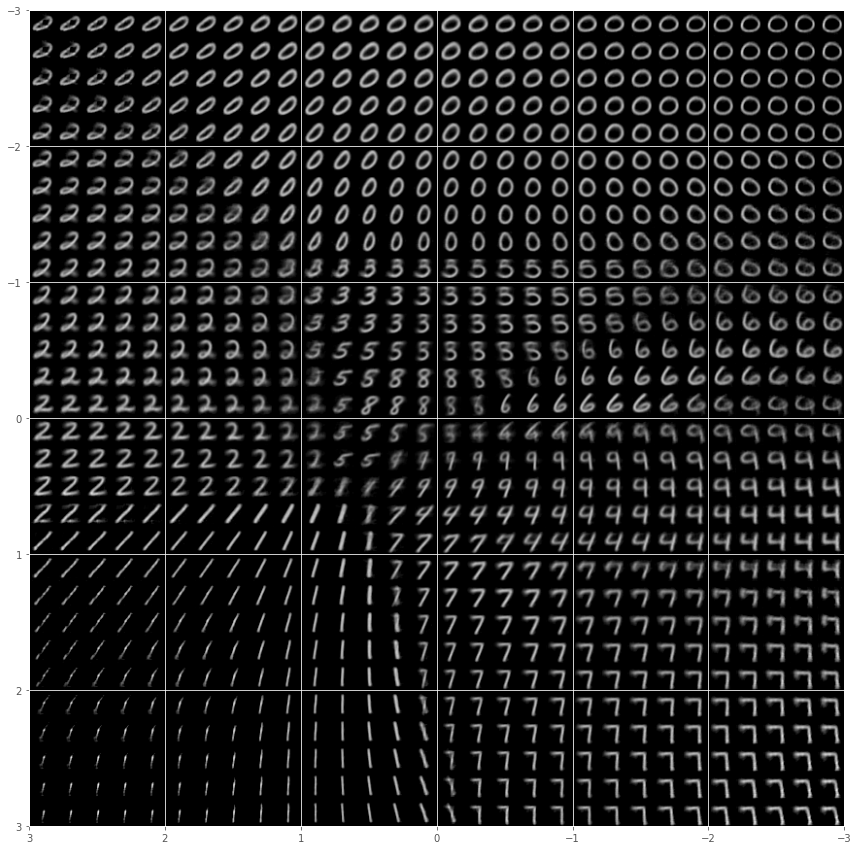

In [ ]:
### Keep in mind we only use the decoder to generate
### the encoder model is used to learn the latent features

generator_model = decoder_model
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()

You can find all the digits(from 0 to 9) in the above image matrix as we have tried to generate images from all the portions of the latent space. The capability of generating handwriting with variations isn’t it awesome!

__PRO TIP__: we typically use VAEs to generate synthetic data when we have limited labeled data, i.e., for model training.

## Summary
This tutorial explains the variational autoencoders in Deep Learning and AI. With a basic introduction, it shows how to implement a VAE with Keras and TensorFlow in python. It further trains the model on MNIST handwritten digit dataset and shows the reconstructed results.

We have seen that the latent encodings are following a standard normal distribution (all thanks to KL-divergence) and how the trained decoder part of the model can be utilized as a generative model. We have proved the claims by generating fake digits using only the decoder part of the model.
